# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Dataset & Modeling</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/advanced_tutorials/air_quality/3_training_dataset_and_modeling.ipynb)

<span style="font-width:bold; font-size: 1.4rem;">This notebook explains how to read from a feature group and create training dataset within the feature store</span>

## 🗒️ This notebook is divided into the following sections:

1. Fetch Feature Groups
2. Define Transformation functions
4. Create Feature Views
5. Create Training Dataset with training, validation and test splits

![part2](../../images/02_training-dataset.png) 

### <span style='color:#ff5f27'> 📝 Imports

In [ ]:
!pip install xgboost --q

In [2]:
import os
import datetime
import time
import json
import pickle
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [5]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/14502
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
air_quality_fg = fs.get_or_create_feature_group(
    name = 'air_quality',
    version = 1
)
weather_fg = fs.get_or_create_feature_group(
    name = 'weather',
    version = 1
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [24]:
query = air_quality_fg.select_all().join(weather_fg.select_all(), on=['city_name', 'date'])

In [ ]:
# here you can check out the merged dataframe
# query_df = query.read()

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.create_feature_view()` method.

You can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=1,
    query=query
)

For now `Feature View` is saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view()`.

---

## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

To create training dataset you use `FeatureView.create_training_data()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- You can choose necessary format using **data_format** parameter.

- **start_time** and **end_time** in order to filter dataset in specific time range.

In [ ]:
td_version, td_job = feature_view.create_training_data(
    description = 'Air Quality dataset',
    data_format = 'csv',
    write_options = {'wait_for_job': True}
)

---

## <span style="color:#ff5f27;">🪝 Training Dataset Retrieval</span>

In [5]:
X, _ = feature_view.get_training_data(
    training_dataset_version=td_version
)

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [8]:
label_encoder = LabelEncoder()

# Fit the encoder to the data
label_encoder.fit(X[['city_name']])

# Transform the data
encoded = label_encoder.transform(X[['city_name']])

In [9]:
# Convert the output to a dense array and concatenate with the original data
X = pd.concat([X, pd.DataFrame(encoded)], axis=1)

X = X.drop(columns=['date', 'city_name', 'unix_time'])
X = X.rename(columns={0: "city_name_encoded"})

In [13]:
y = X.pop('pm2_5')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### <span style='color:#ff5f27'> ⚖️ Model Validation

In [34]:
start_of_cell = time.time()

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

# calculate MSE using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# calculate RMSE using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

MSE: 29.182665583297467
RMSE: 5.402098257464174
R squared: 0.7363832908625316
Took 10.65 sec.



In [35]:
df_ = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})

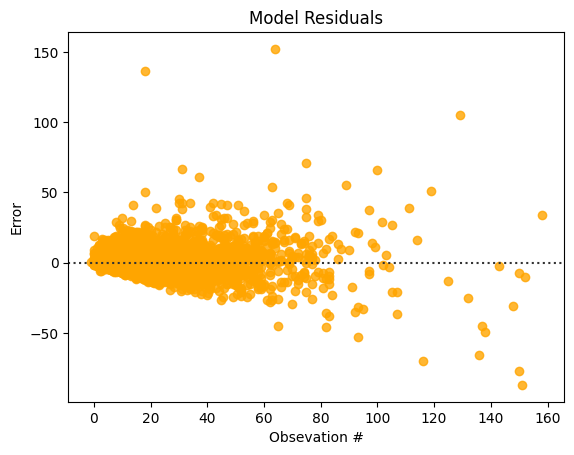

In [36]:
residplot = sns.residplot(data=df_, x="y_true", y="y_pred", color='orange')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()
fig = residplot.get_figure()
fig.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

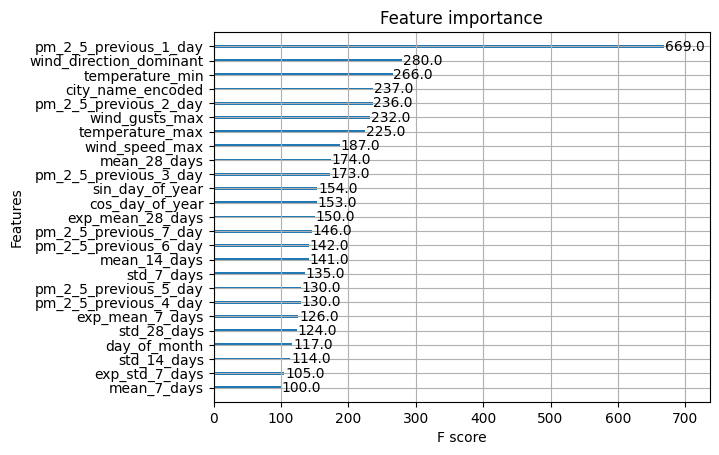

In [19]:
from xgboost import plot_importance


plot_importance(xgb_regressor, max_num_features=25)

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [50]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [25]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X)
output_schema = Schema(y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'pm_2_5_previous_1_day',
    'type': 'float64'},
   {'name': 'pm_2_5_previous_2_day', 'type': 'float64'},
   {'name': 'pm_2_5_previous_3_day', 'type': 'float64'},
   {'name': 'pm_2_5_previous_4_day', 'type': 'float64'},
   {'name': 'pm_2_5_previous_5_day', 'type': 'float64'},
   {'name': 'pm_2_5_previous_6_day', 'type': 'float64'},
   {'name': 'pm_2_5_previous_7_day', 'type': 'float64'},
   {'name': 'mean_7_days', 'type': 'float64'},
   {'name': 'mean_14_days', 'type': 'float64'},
   {'name': 'mean_28_days', 'type': 'float64'},
   {'name': 'std_7_days', 'type': 'float64'},
   {'name': 'exp_mean_7_days', 'type': 'float64'},
   {'name': 'exp_std_7_days', 'type': 'float64'},
   {'name': 'std_14_days', 'type': 'float64'},
   {'name': 'exp_mean_14_days', 'type': 'float64'},
   {'name': 'exp_std_14_days', 'type': 'float64'},
   {'name': 'std_28_days', 'type': 'float64'},
   {'name': 'exp_mean_28_days', 'type': 'float64'},
   {'name': 'exp_std_28

In [44]:
# The 'nyc_taxi_fares_model' directory will be saved to the model registry
model_dir="air_quality_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(label_encoder, model_dir + '/label_encoder.pkl')
joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')

fig.savefig(model_dir + "/residplot.png") 

In [45]:
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2
    },
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor.")

aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/14502/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

---

## <span style="color:#ff5f27;">🪝 Retrieving model from Model Registry</span>

In [56]:
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1
)

saved_model_dir = retrieved_model.download()

In [57]:
retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_encoder = joblib.load(saved_model_dir + "/label_encoder.pkl")

In [58]:
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Load Batch Data of last days</span>

First, you will need to fetch the training dataset that you created in the previous notebook.

In [3]:
today = datetime.date.today()
date_threshold = today - datetime.timedelta(days=30)
str(date_threshold)

'2023-03-21'

In [9]:
start_of_cell = time.time()


feature_view.init_batch_scoring(training_dataset_version=td_version)

batch_data = feature_view.get_batch_data(start_time=date_threshold)


end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

2023-04-20 10:11:41,109 INFO: USE `test5_featurestore`
2023-04-20 10:11:41,749 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`city_name` `city_name`, `fg1`.`date` `date`, `fg1`.`pm2_5` `pm2_5`, `fg1`.`pm_2_5_previous_1_day` `pm_2_5_previous_1_day`, `fg1`.`pm_2_5_previous_2_day` `pm_2_5_previous_2_day`, `fg1`.`pm_2_5_previous_3_day` `pm_2_5_previous_3_day`, `fg1`.`pm_2_5_previous_4_day` `pm_2_5_previous_4_day`, `fg1`.`pm_2_5_previous_5_day` `pm_2_5_previous_5_day`, `fg1`.`pm_2_5_previous_6_day` `pm_2_5_previous_6_day`, `fg1`.`pm_2_5_previous_7_day` `pm_2_5_previous_7_day`, `fg1`.`mean_7_days` `mean_7_days`, `fg1`.`mean_14_days` `mean_14_days`, `fg1`.`mean_28_days` `mean_28_days`, `fg1`.`std_7_days` `std_7_days`, `fg1`.`exp_mean_7_days` `exp_mean_7_days`, `fg1`.`exp_std_7_days` `exp_std_7_days`, `fg1`.`std_14_days` `std_14_days`, `fg1`.`exp_mean_14_days` `exp_mean_14_days`, `fg1`.`exp_std_14_days` `exp_std_14_days`, `fg1`.`std_28_days` `std_28_days`, `fg1`.`exp_mean_28_days` `exp_

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [61]:
# Transform the data
encoded = retrieved_encoder.transform(batch_data['city_name'])

# Convert the output to a dense array and concatenate with the original data
X_batch = pd.concat([batch_data, pd.DataFrame(encoded)], axis=1)

X_batch = X_batch.drop(columns=['date', 'city_name', 'unix_time'])
X_batch = X_batch.rename(columns={0: 'city_name_encoded'})

y_batch = X_batch.pop('pm2_5')

In [63]:
predictions = retrieved_xgboost_model.predict(X_batch)
predictions[:5]

array([9.64364 , 7.431512, 5.529407, 4.530392, 5.51446 ], dtype=float32)

---

## <span style="color:#ff5f27;">👾 Now try out the Streamlit App!</span>

In [64]:
# install dependcies
!pip3 install streamlit-folium --q

---

### <span style="color:#ff5f27;">🥳 <b> Next Steps </b> </span>

Check out our other tutorials on ➡ https://github.com/logicalclocks/hopsworks-tutorials

Or documentation at ➡ https://docs.hopsworks.ai

In [11]:
with open('target_cities.json') as json_file:
    target_cities = json.load(json_file)

In [13]:
from functions import *

In [14]:
last_dates_aq = batch_data[["date", "city_name"]].groupby("city_name").max()
last_dates_aq.date = last_dates_aq.date.astype(str)

# here is a dictionary with city names as keys and last updated date as values
last_dates_aq = last_dates_aq.to_dict()["date"]

start_of_cell = time.time()

df_aq_update = pd.DataFrame()

for continent in target_cities:
    for city_name, coords in target_cities[continent].items():
        df_ = get_aqi_data_from_open_meteo(city_name=city_name,
                                           coordinates=coords,
                                           start_date=last_dates_aq[city_name],
                                           end_date=str(today))
        df_aq_update = pd.concat([df_aq_update, df_]).reset_index(drop=True)
    
end_of_cell = time.time()
print("-" * 64)
print(f"Parsed new PM2.5 data for ALL locations up to {str(today)}.")
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

# we need the previous data to calculate aggregation functions
df_air_quality_new = pd.concat([
    batch_data[df_aq_update.columns],
    df_aq_update
]).reset_index(drop=True)
df_air_quality_new = df_air_quality_new.drop_duplicates(subset=['city_name', 'date'])

Processed PM2_5 for NORTH BEND - NORTH BEND WAY since 2023-04-17 till 2023-04-20.
Took 0.15 sec.

Processed PM2_5 for LAKE FOREST PARK TOWNE CENTER since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for SEATTLE - DUWAMISH since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for SEATTLE - BEACON HILL since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for SEATTLE - SOUTH PARK #2 since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for KENT - JAMES & CENTRAL since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for TACOMA - L STREET since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for TACOMA - ALEXANDER AVE since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for DARRINGTON - FIR ST (Darrington High School) since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for MARYSVILLE - 7TH AVE (Marysville Junior High) since 2023-04-17 till 2023-04-20.
Took 0.14 sec.

Processed PM2_5 for Se

In [15]:
df_air_quality_new

,city_name,date,pm2_5
0,Albuquerque,2023-03-22,8.8
1,Albuquerque,2023-03-23,2.6
2,Albuquerque,2023-03-24,7.6
3,Albuquerque,2023-03-25,9.3
4,Albuquerque,2023-03-26,11.9
...,...,...,...
910,San Francisco,2023-04-20,10.8
911,Tampa,2023-04-17,9.0
912,Tampa,2023-04-18,4.5
913,Tampa,2023-04-19,9.3
